# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import time
import nltk
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from wordcloud import WordCloud
from sklearn.metrics import (
    f1_score,
    jaccard_score,
    hamming_loss,
    accuracy_score,
    classification_report,
    multilabel_confusion_matrix
)

In [3]:
from functions import clean_text, simple_tokenize_and_stem, parse_classes

# Data and its Information

In [5]:
df = pd.read_csv('drugs_side_effects_drugs_com.csv')
df.head()

,drug_name,medical_condition,side_effects,generic_name,drug_classes,brand_names,activity,rx_otc,pregnancy_category,csa,alcohol,related_drugs,medical_condition_description,rating,no_of_reviews,drug_link,medical_condition_url
0,doxycycline,Acne,"(hives, difficult breathing, swelling in your ...",doxycycline,"Miscellaneous antimalarials, Tetracyclines","Acticlate, Adoxa CK, Adoxa Pak, Adoxa TT, Alod...",87%,Rx,D,N,X,amoxicillin: https://www.drugs.com/amoxicillin...,Acne Other names: Acne Vulgaris; Blackheads; B...,6.8,760.0,https://www.drugs.com/doxycycline.html,https://www.drugs.com/condition/acne.html
1,spironolactone,Acne,hives ; difficulty breathing; swelling of your...,spironolactone,"Aldosterone receptor antagonists, Potassium-sp...","Aldactone, CaroSpir",82%,Rx,C,N,X,amlodipine: https://www.drugs.com/amlodipine.h...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.2,449.0,https://www.drugs.com/spironolactone.html,https://www.drugs.com/condition/acne.html
2,minocycline,Acne,"skin rash, fever, swollen glands, flu-like sym...",minocycline,Tetracyclines,"Dynacin, Minocin, Minolira, Solodyn, Ximino, V...",48%,Rx,D,N,NaN,amoxicillin: https://www.drugs.com/amoxicillin...,Acne Other names: Acne Vulgaris; Blackheads; B...,5.7,482.0,https://www.drugs.com/minocycline.html,https://www.drugs.com/condition/acne.html
3,Accutane,Acne,problems with your vision or hearing; muscle o...,isotretinoin (oral),"Miscellaneous antineoplastics, Miscellaneous u...",NaN,41%,Rx,X,N,X,doxycycline: https://www.drugs.com/doxycycline...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.9,623.0,https://www.drugs.com/accutane.html,https://www.drugs.com/condition/acne.html
4,clindamycin,Acne,hives ; difficult breathing; swelling of your ...,clindamycin topical,"Topical acne agents, Vaginal anti-infectives","Cleocin T, Clindacin ETZ, Clindacin P, Clindag...",39%,Rx,B,N,NaN,doxycycline: https://www.drugs.com/doxycycline...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.4,146.0,https://www.drugs.com/mtm/clindamycin-topical....,https://www.drugs.com/condition/acne.html


In [6]:
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

Dataset shape: (2931, 17)
Columns: ['drug_name', 'medical_condition', 'side_effects', 'generic_name', 'drug_classes', 'brand_names', 'activity', 'rx_otc', 'pregnancy_category', 'csa', 'alcohol', 'related_drugs', 'medical_condition_description', 'rating', 'no_of_reviews', 'drug_link', 'medical_condition_url']


In [7]:
print("Dataset Info: ", df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2931 entries, 0 to 2930
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   drug_name                      2931 non-null   object 
 1   medical_condition              2931 non-null   object 
 2   side_effects                   2807 non-null   object 
 3   generic_name                   2888 non-null   object 
 4   drug_classes                   2849 non-null   object 
 5   brand_names                    1718 non-null   object 
 6   activity                       2931 non-null   object 
 7   rx_otc                         2930 non-null   object 
 8   pregnancy_category             2702 non-null   object 
 9   csa                            2931 non-null   object 
 10  alcohol                        1377 non-null   object 
 11  related_drugs                  1462 non-null   object 
 12  medical_condition_description  2931 non-null   o

In [8]:
print("\nTotal rows:", len(df))
print("Unique drug_classes entries:", df['drug_classes'].nunique())
print("Unique generic names:", df['generic_name'].nunique())


Total rows: 2931
Unique drug_classes entries: 274
Unique generic names: 1392


# Data Pre-processing and Exploratory Data Analysis

In [10]:
# Missing value overview
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]

alcohol               1554
related_drugs         1469
rating                1345
no_of_reviews         1345
brand_names           1213
pregnancy_category     229
side_effects           124
drug_classes            82
generic_name            43
rx_otc                   1
dtype: int64

## Imputation of null values and dropping unnecessary columns

In [12]:
df['rating'] = df['rating'].fillna(df['rating'].median())
df['no_of_reviews'] = df['no_of_reviews'].fillna(df['no_of_reviews'].median())
df['drug_classes'] = df['drug_classes'].fillna('Unknown')
df['side_effects'] = df['side_effects'].fillna('Unknown')

In [13]:
df['activity'] = df['activity'] = (
    df['activity']
    .astype(str)                      # ensure string type
    .str.replace('%', '', regex=False) # remove '%'
    .str.strip()                       # remove extra spaces
    .replace('', None)                 # replace empty strings with None
    .astype(float)                     # convert to float
)

In [14]:
df = df.drop('alcohol', axis=1)

## Pre-process Text Columns

In [15]:
TEXT_COLUMNS = ['generic_name', 'brand_names', 'medical_condition', 'side_effects', 'medical_condition_description']
# Ensure columns exist
for c in TEXT_COLUMNS:
    if c not in df.columns:
        df[c] = ""

# Combine
df['combined_text_raw'] = (
    df['generic_name'].fillna("") + " "
    + df['brand_names'].fillna("") + " "
    + df['medical_condition'].fillna("") + " "
    + df['side_effects'].fillna("") + " "
    + df['medical_condition_description'].fillna("")
)

# Clean
df['combined_text_clean'] = df['combined_text_raw'].apply(clean_text).apply(simple_tokenize_and_stem)
df[['combined_text_raw','combined_text_clean']].head(3)

,combined_text_raw,combined_text_clean
0,"doxycycline Acticlate, Adoxa CK, Adoxa Pak, Ad...","doxycyclin acticlate, adoxa ck, adoxa pak, ado..."
1,"spironolactone Aldactone, CaroSpir Acne hives ...","spironolacton aldactone, carospir acn hive dif..."
2,"minocycline Dynacin, Minocin, Minolira, Solody...","minocyclin dynacin, minocin, minolira, solodyn..."


## Pre-process Drug Classes Column

In [16]:
df['classes_list'] = df['drug_classes'].apply(parse_classes)
df[['drug_classes','classes_list']].head(6)

,drug_classes,classes_list
0,"Miscellaneous antimalarials, Tetracyclines","[miscellaneous antimalarials, tetracyclines]"
1,"Aldosterone receptor antagonists, Potassium-sp...","[aldosterone receptor antagonists, potassium s..."
2,Tetracyclines,[tetracyclines]
3,"Miscellaneous antineoplastics, Miscellaneous u...","[miscellaneous antineoplastics, miscellaneous ..."
4,"Topical acne agents, Vaginal anti-infectives","[topical acne agents, vaginal anti infectives]"
5,"Aldosterone receptor antagonists, Potassium-sp...","[aldosterone receptor antagonists, potassium s..."


## Visualization of Drug Labels

Total unique parsed labels: 252


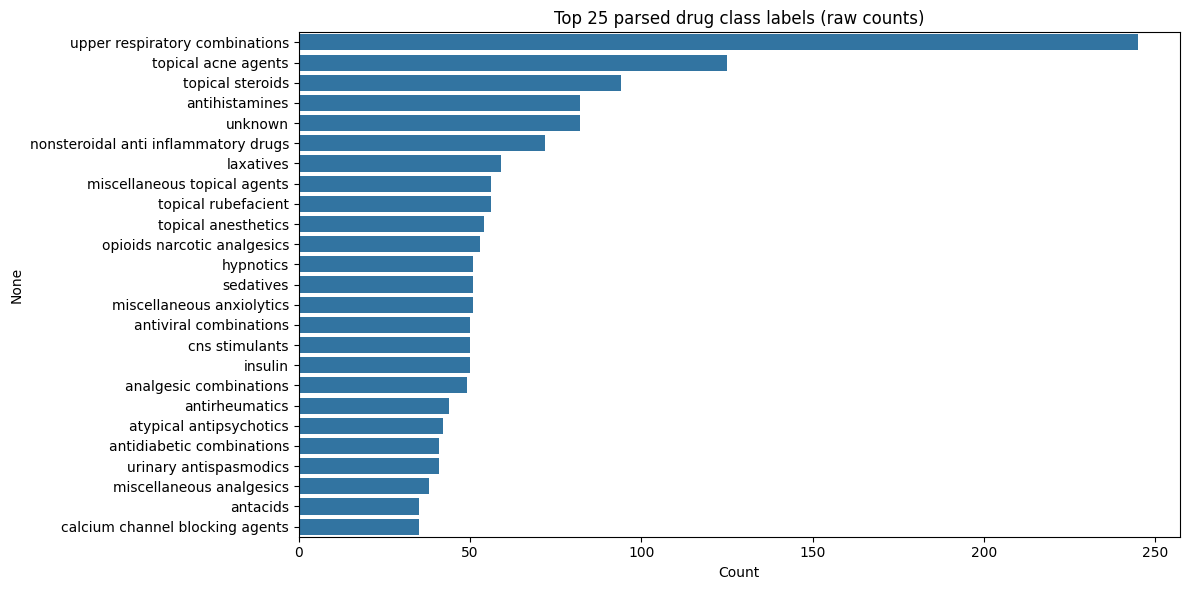

In [17]:
# Flatten and count labels
all_labels = [lab for labs in df['classes_list'] for lab in labs]
label_counts = Counter(all_labels)
print("Total unique parsed labels:", len(label_counts))

# Show top 25 labels
top = pd.Series(label_counts).sort_values(ascending=False).head(25)
plt.figure(figsize=(12,6))
sns.barplot(x=top.values, y=top.index)
plt.title("Top 25 parsed drug class labels (raw counts)")
plt.xlabel("Count")
plt.tight_layout()
plt.show()

## Visualization of Side Effects

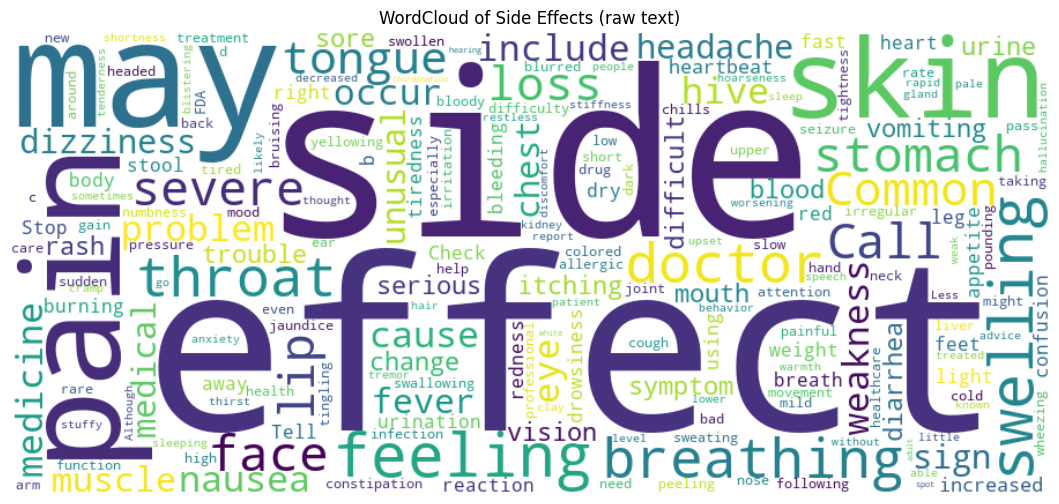

In [18]:
side_text = " ".join(df['side_effects'].dropna().astype(str).tolist())
wc = WordCloud(width=900, height=400, background_color="white", collocations=False).generate(side_text)

plt.figure(figsize=(14,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Side Effects (raw text)")
plt.show()

In [19]:
# Filter labels with few samples
valid_labels = {lab for lab, cnt in label_counts.items() if cnt >= 3}
print(f"Labels with >= {3} examples: {len(valid_labels)} of {len(label_counts)}")

df['classes_list_filtered'] = df['classes_list'].apply(lambda labs: [l for l in labs if l in valid_labels])
before = len(df)
df = df[df['classes_list_filtered'].map(len) > 0].reset_index(drop=True)
after = len(df)
print(f"Rows before label filtering: {before}; after filtering: {after} (removed {before-after})")

Labels with >= 3 examples: 194 of 252
Rows before label filtering: 2931; after filtering: 2856 (removed 75)


# Prdictive Modelling

## Train-Test Split for Model and Model Training

In [20]:
X = df['combined_text_clean'].values
mlb = MultiLabelBinarizer(sparse_output=False)
Y = mlb.fit_transform(df['classes_list_filtered'].values)

print("X shape:", X.shape)
print("Y shape:", Y.shape)
print("Number of labels:", len(mlb.classes_))

X shape: (2856,)
Y shape: (2856, 194)
Number of labels: 194


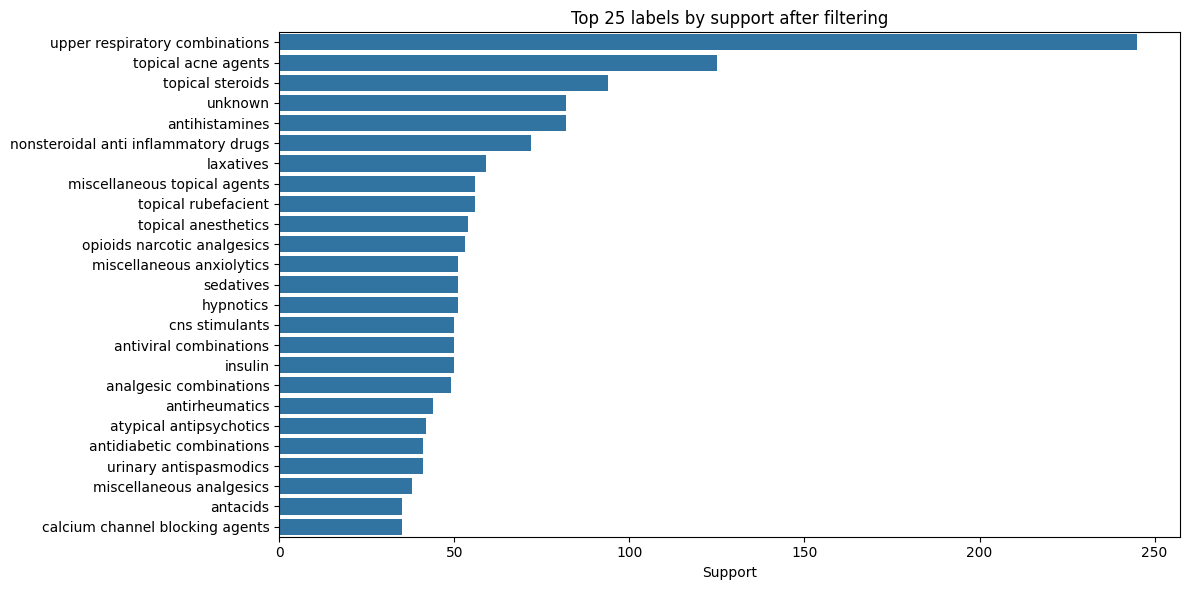

In [21]:
label_df = pd.DataFrame({'label': mlb.classes_, 'support': Y.sum(axis=0)}).sort_values('support', ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=label_df['support'].values[:25], y=label_df['label'].values[:25])
plt.title("Top 25 labels by support after filtering")
plt.xlabel("Support")
plt.tight_layout()
plt.show()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
print("Train size:", len(X_train), "Test size:", len(X_test))

tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 2), min_df=3)
classifier = OneVsRestClassifier(LinearSVC(max_iter=1500, dual=True), n_jobs=1)
pipeline = Pipeline([("tfidf", tfidf), ("clf", classifier)])

# Train
t0 = time.time()
print("Training pipeline...")
pipeline.fit(X_train, y_train)
print("Training finished in {:.1f}s".format(time.time()-t0))

Train size: 2142 Test size: 714
Training pipeline...
Training finished in 4.6s


## Model Evaluation

In [23]:
y_pred = pipeline.predict(X_test)
micro_f1 = f1_score(y_test, y_pred, average='micro', zero_division=0)
macro_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
jaccard = jaccard_score(y_test, y_pred, average='samples', zero_division=0)
hamming = hamming_loss(y_test, y_pred)
subset_acc = accuracy_score(y_test, y_pred)

print(f"Micro F1-score: {micro_f1:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Jaccard (samples avg): {jaccard:.4f}")
print(f"Hamming Loss: {hamming:.4f}")
print(f"Subset (exact-match) Accuracy: {subset_acc:.4f}")

Micro F1-score: 0.6503
Macro F1-score: 0.2994
Jaccard (samples avg): 0.5347
Hamming Loss: 0.0034
Subset (exact-match) Accuracy: 0.5182


In [24]:
# Show classification report for top K labels by support
supports = Y.sum(axis=0)
label_support_df = pd.DataFrame({'label': mlb.classes_, 'support': supports}).sort_values('support', ascending=False)
top_k = min(20, len(mlb.classes_))
top_labels = label_support_df['label'].iloc[:top_k].tolist()

# Get indices for top labels
top_indices = [list(mlb.classes_).index(l) for l in top_labels]
print("Top labels:", top_labels)

# Print report restricted to top labels
print(classification_report(y_test[:, top_indices], y_pred[:, top_indices], zero_division=0, target_names=top_labels))

Top labels: ['upper respiratory combinations', 'topical acne agents', 'topical steroids', 'unknown', 'antihistamines', 'nonsteroidal anti inflammatory drugs', 'laxatives', 'miscellaneous topical agents', 'topical rubefacient', 'topical anesthetics', 'opioids narcotic analgesics', 'miscellaneous anxiolytics', 'sedatives', 'hypnotics', 'cns stimulants', 'antiviral combinations', 'insulin', 'analgesic combinations', 'antirheumatics', 'atypical antipsychotics']
                                      precision    recall  f1-score   support

      upper respiratory combinations       0.94      0.96      0.95        53
                 topical acne agents       0.68      0.96      0.79        28
                    topical steroids       0.81      0.91      0.86        23
                             unknown       0.00      0.00      0.00        18
                      antihistamines       0.82      0.64      0.72        22
nonsteroidal anti inflammatory drugs       0.82      0.93      0.88  

## Evaluation Visualization

In [25]:
cm = multilabel_confusion_matrix(y_test, y_pred)

tp = cm[:,1,1]
fp = cm[:,0,1]
fn = cm[:,1,0]

label_names = mlb.classes_

conf_df = pd.DataFrame({
    "label": label_names,
    "TP": tp,
    "FP": fp,
    "FN": fn
}).sort_values("TP", ascending=False)

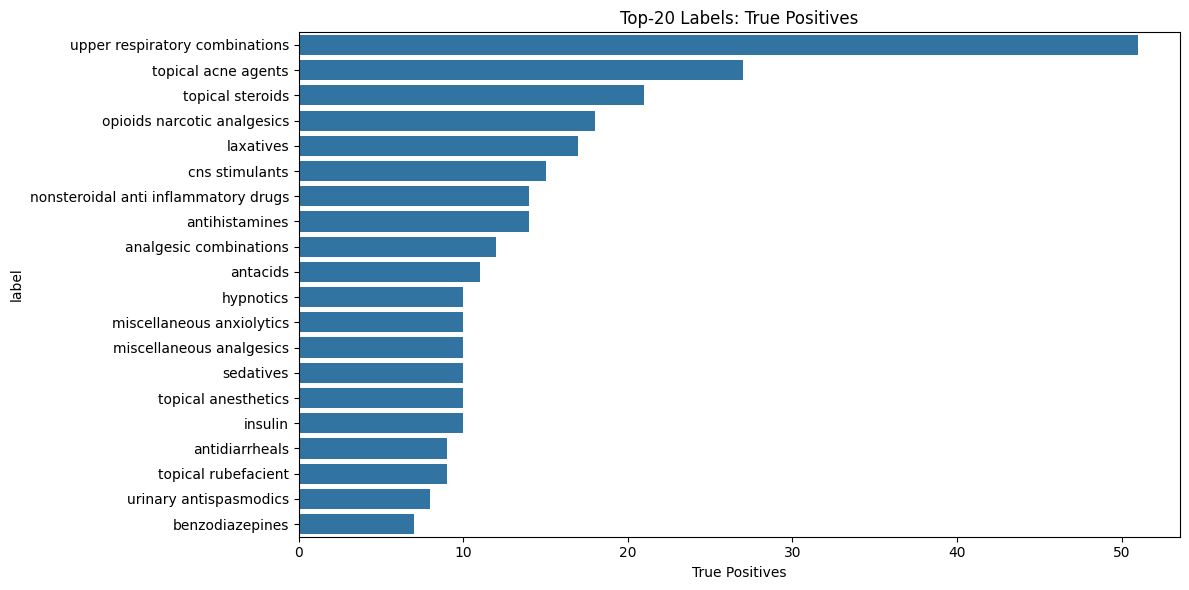

In [26]:
plt.figure(figsize=(12,6))
sns.barplot(y=conf_df["label"][:20], x=conf_df["TP"][:20])
plt.title("Top-20 Labels: True Positives")
plt.xlabel("True Positives")
plt.tight_layout()
plt.show()

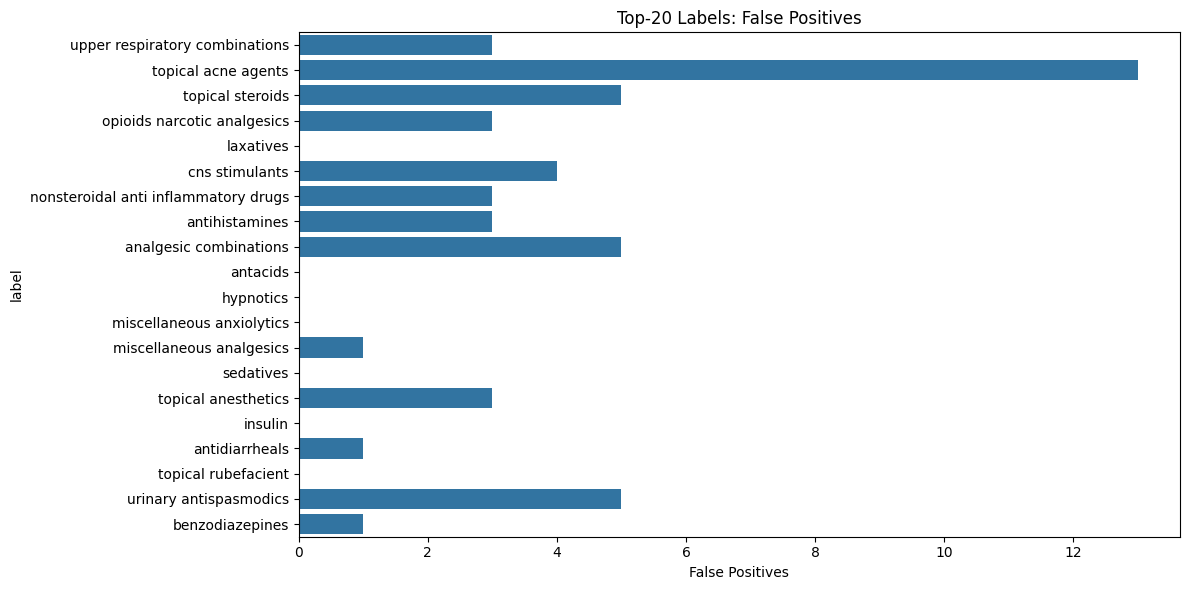

In [27]:
plt.figure(figsize=(12,6))
sns.barplot(y=conf_df["label"][:20], x=conf_df["FP"][:20])
plt.title("Top-20 Labels: False Positives")
plt.xlabel("False Positives")
plt.tight_layout()
plt.show()

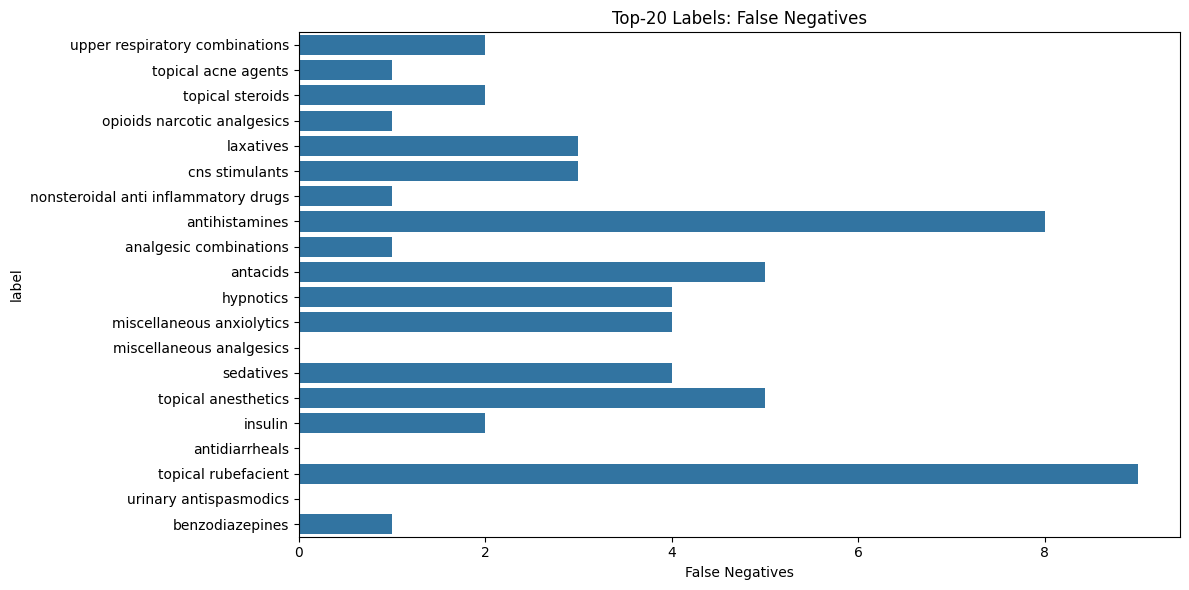

In [28]:
plt.figure(figsize=(12,6))
sns.barplot(y=conf_df["label"][:20], x=conf_df["FN"][:20])
plt.title("Top-20 Labels: False Negatives")
plt.xlabel("False Negatives")
plt.tight_layout()
plt.show()

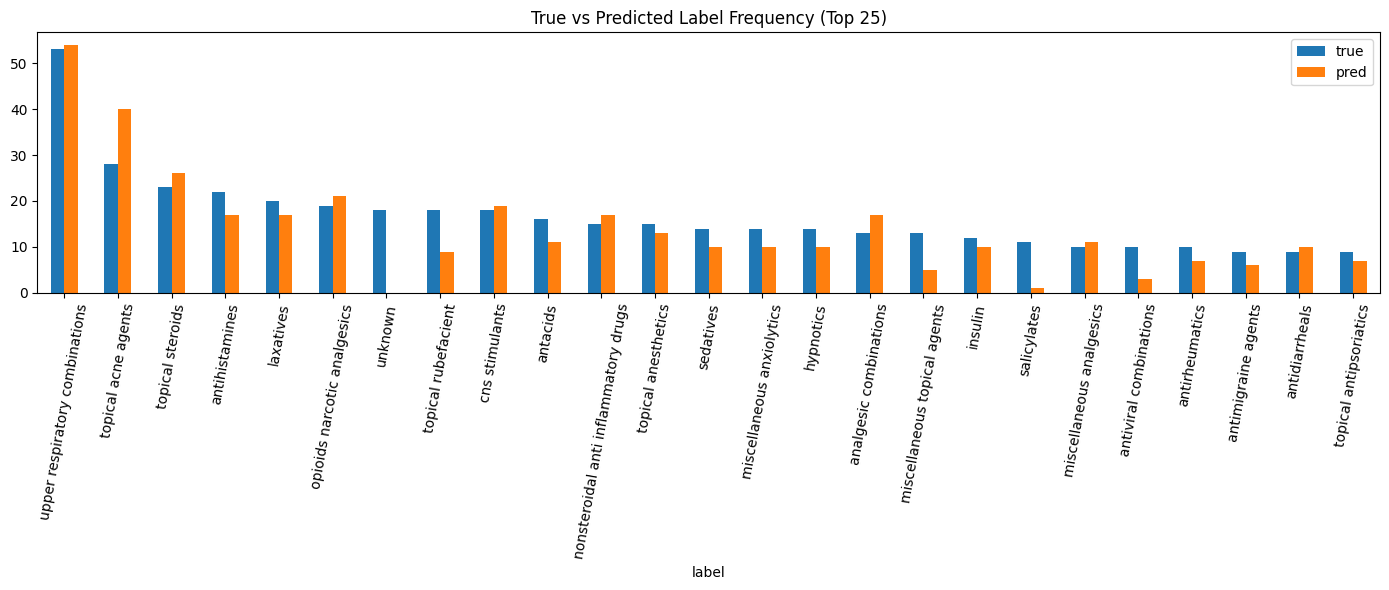

In [29]:

true_freq = y_test.sum(axis=0)
pred_freq = y_pred.sum(axis=0)

freq_df = pd.DataFrame({
    "label": mlb.classes_,
    "true": true_freq,
    "pred": pred_freq
}).sort_values("true", ascending=False).head(25)

freq_df.plot(
    x="label",
    y=["true", "pred"],
    kind="bar",
    figsize=(14,6)
)
plt.xticks(rotation=80)
plt.title("True vs Predicted Label Frequency (Top 25)")
plt.tight_layout()
plt.show()